# Error Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns



from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.data.hdf_functions import print_tree, load_dataframe_from_HDF5
from fault_management_uds.plots import visualize_indicator_dict



from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import natural_sensor_order, natural_structure_order, structure_2_sensor, error_indicators, bools_2_meta

2024-11-16 09:21:30.955 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [2]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
f = print_tree(data_file_path)

root
├── combined_data
│   ├── clean
│   │   ├── columns
│   │   ├── data
│   │   └── timestamps
│   └── raw
│       ├── columns
│       ├── data
│       └── timestamps
└── single_series
    ├── rain_gauge_data
    │   ├── 5425
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── 5427
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── sewer_data
        ├── G71F04R_Level1
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   └── raw
        │       ├── columns
        │       ├── data
        │       └── timestamps
        ├── G71F04R_Level2
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │ 

In [3]:
sensor_metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
external_metadata = import_metadata(REFERENCE_DIR / 'external_metadata.csv')
starttime = sensor_metadata['StartTime'].min()
endtime = sensor_metadata['EndTime'].max()

In [4]:
save_folder = FIGURES_DIR / 'analysis' / 'errors'
os.makedirs(save_folder, exist_ok=True)

## Create a error dataframe

plot sum or hist of errors for:

- sensor
- scada system
- rain event or not
- year
- month
- day of week
- hour
- above avg or median

In [ ]:
# load the rain events
rain_events = pd.read_csv(REFERENCE_DIR / 'events' / 'rain_events.csv')
rain_events['start'] = pd.to_datetime(rain_events['start'])
rain_events['end'] = pd.to_datetime(rain_events['end'])
print(rain_events.shape)
rain_events.head()

(2033, 4)


,start,end,duration,total_rain
0,2010-01-11 18:37:00,2010-01-12 03:12:00,530,123.296
1,2010-01-27 13:53:00,2010-01-27 16:17:00,159,36.689
2,2010-01-29 23:51:00,2010-01-30 02:21:00,165,43.327
3,2010-01-31 02:53:00,2010-01-31 03:48:00,70,23.345
4,2010-02-02 11:22:00,2010-02-02 15:20:00,253,69.968


In [6]:
error_rows = []

columns = ['structure', 'sensor', 'error']

for structure, _structure_2_sensor in tqdm(structure_2_sensor.items(), total=len(structure_2_sensor)):
    for sensor_name in _structure_2_sensor:
        meta = external_metadata[external_metadata['IdMeasurement'] == sensor_name]
        # iterate each metadata
        for _, _meta in meta.iterrows():
            starttime = _meta['StartTime']
            endtime = _meta['EndTime']
            # get bools
            bools, _, _, _ = load_dataframe_from_HDF5(data_file_path, f'single_series/sewer_data/{sensor_name}/bools', starttime=starttime, endtime=endtime, complete_range=True, verbose=False)
            bools = bools[error_indicators]
            raw, _, _, _ = load_dataframe_from_HDF5(data_file_path, f'single_series/sewer_data/{sensor_name}/raw', starttime=starttime, endtime=endtime, complete_range=True, verbose=False)
            
            # extract only rows with error
            error_mask = bools.any(axis=1)
            bools = bools[error_mask]
            raw = raw[error_mask]
            
            # add metadata
            bools['structure'] = structure
            bools['sensor'] = sensor_name
            bools['source'] = _meta['Source']
            bools['raw'] = raw
            
            # check if the error is within a rain event
            is_within_rain_event = pd.Series(False, index=bools.index)
            # Iterate over each rain event and update the boolean array
            for _, event in rain_events.iterrows():
                is_within_rain_event |= (bools.index >= event['start']) & (bools.index <= event['end'])
            # Convert the Series to a list if needed
            is_within_rain_event = is_within_rain_event.tolist()
            bools['rain_event'] = is_within_rain_event
            
            # time features
            bools['year'] = bools.index.year
            bools['month'] = bools.index.month
            bools['day_of_week'] = bools.index.dayofweek
            bools['hour'] = bools.index.hour
            bools['minute'] = bools.index.minute

            # append to the error_rows
            error_rows.append(bools)

error_df = pd.concat(error_rows)

100%|██████████| 9/9 [01:51<00:00, 12.43s/it]


In [7]:
error_df.shape

(4543738, 15)

In [8]:
error_df.head(3)

,man_remove,stamp,outbound,outlier,frozen,structure,sensor,source,raw,rain_event,year,month,day_of_week,hour,minute
2019-10-23 12:26:00,False,True,False,False,False,G80F11B,G80F11B_Level1,iFix,0.0,0.0,2019,10,2,12,26
2019-10-24 07:25:00,False,True,False,False,False,G80F11B,G80F11B_Level1,iFix,0.0,0.0,2019,10,3,7,25
2019-10-24 09:17:00,False,True,False,False,False,G80F11B,G80F11B_Level1,iFix,0.0,0.0,2019,10,3,9,17


In [9]:
error_df['rain_event'] = error_df['rain_event'].astype(bool)

## Barplots

In [10]:
def plot_counts(ax, df, column, order=None, kind='bar', color='#9291f3'):

    # Count the occurrences of each category in the specified column
    counts = df[column].value_counts()#.reindex(order)
    
    # if order specified, then reindex
    if order is not None:
        counts = counts.reindex(order)
        # fill na with 0
        counts = counts.fillna(0)
    else:
        # order by key name
        counts = counts.sort_index()

    # Plot the bar chart
    counts.plot(kind=kind, ax=ax, color=color)

    # Add counts on top of each bar
    for i, count in enumerate(counts):
        formatted_count = f"{int(count):,}".replace(',', ' ')
        if kind == 'bar':
            ax.text(i, count, formatted_count, ha='center', va='bottom')
            # rotate x labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        else:
            ax.text(count, i, formatted_count, ha='left', va='center')
            # invert y-axis
            ax.invert_yaxis()

    # remove y-axis label
    ax.set_ylabel('')
    ax.set_xlabel('')
    return ax

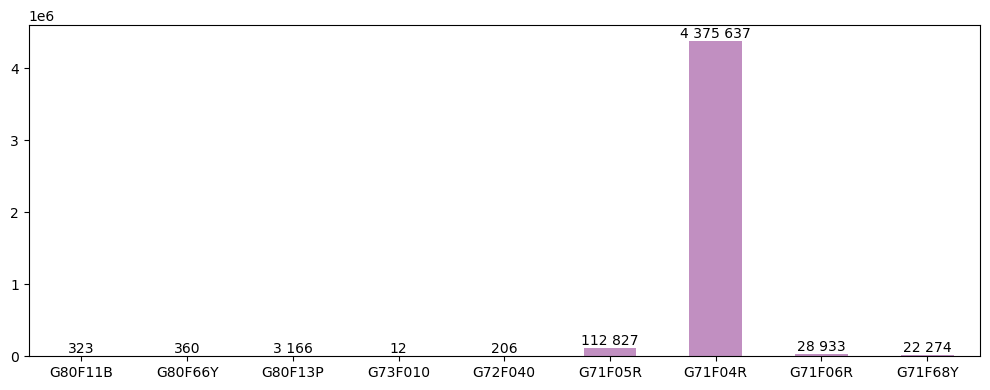

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
column = 'structure'
ax = plot_counts(ax, error_df, column, natural_structure_order, kind='bar', color='#c18fc1')
plt.tight_layout()
plt.show()
plt.close() 

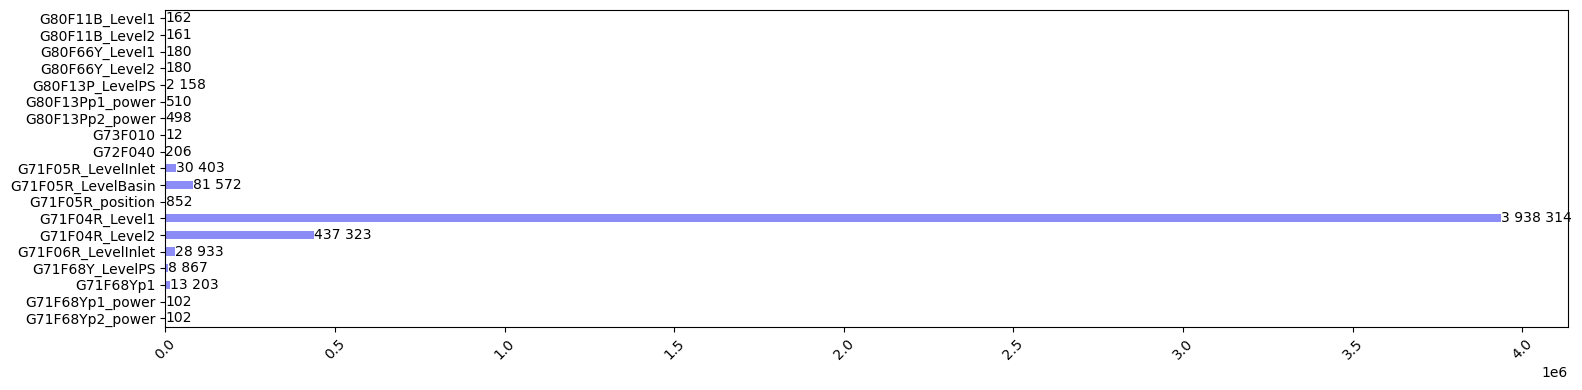

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
column = 'sensor'
ax = plot_counts(ax, error_df, column, natural_sensor_order, kind='barh', color='#8c8cf7')
# rotate x ticks
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close() 

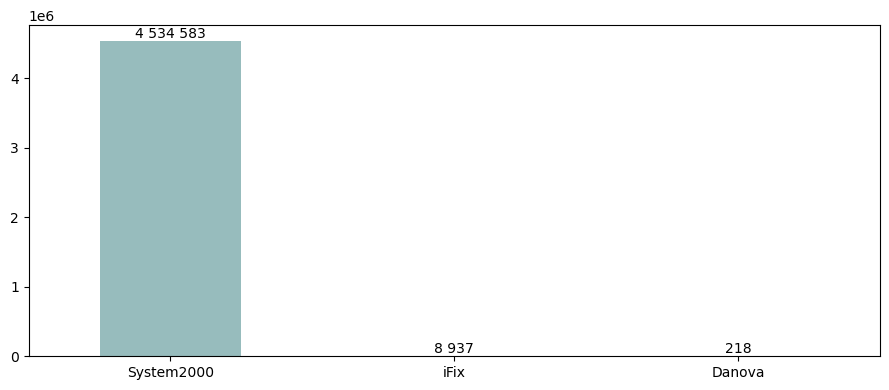

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
column = 'source'
ax = plot_counts(ax, error_df, column, ['System2000', 'iFix', 'Danova'], kind='bar', color='#97bcbd')
plt.tight_layout()
plt.show()
plt.close() 

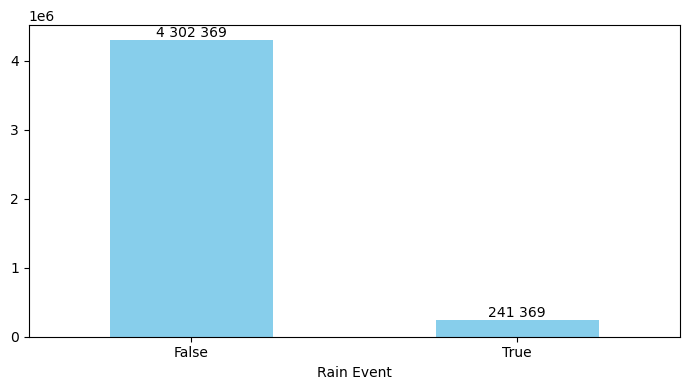

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
column = 'rain_event'
ax = plot_counts(ax, error_df, column, kind='bar', color='skyblue')
ax.set_xlabel('Rain Event')
plt.tight_layout()
plt.show()
plt.close() 

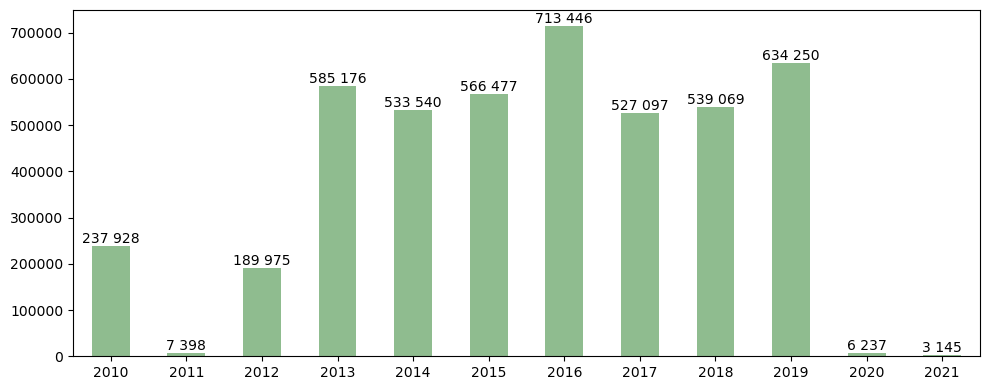

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
column = 'year'
ax = plot_counts(ax, error_df, column, kind='bar', color='darkseagreen')
plt.tight_layout()
plt.show()
plt.close() 

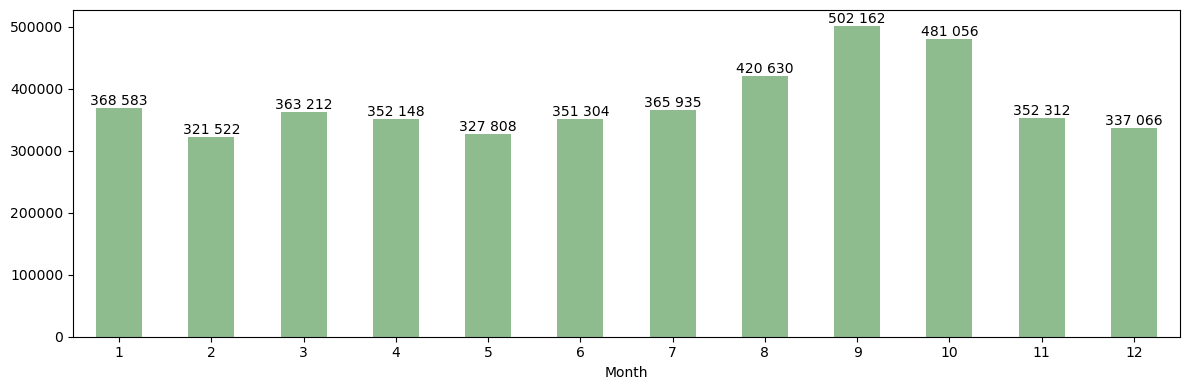

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
column = 'month'
ax = plot_counts(ax, error_df, column, kind='bar', color='darkseagreen')
ax.set_xlabel('Month')
plt.tight_layout()
plt.savefig(save_folder / 'error_month.png')
plt.show()
plt.close() 

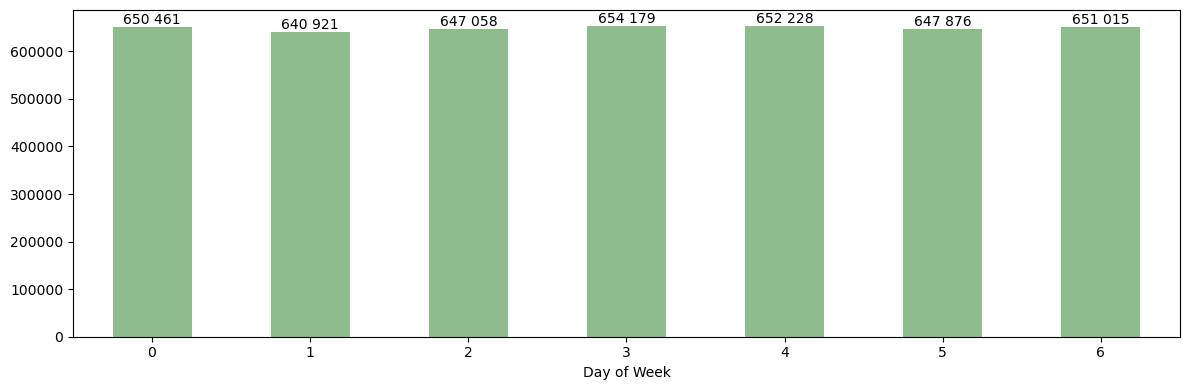

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
column = 'day_of_week'
ax = plot_counts(ax, error_df, column, kind='bar', color='darkseagreen')
ax.set_xlabel('Day of Week')
plt.tight_layout()
plt.show()
plt.close() 

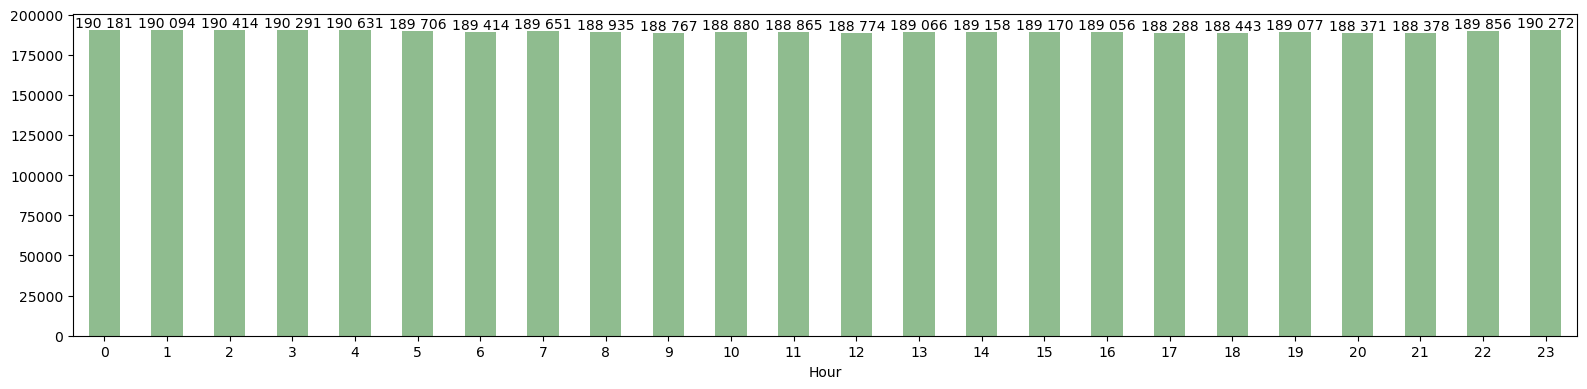

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
column = 'hour'
ax = plot_counts(ax, error_df, column, kind='bar', color='darkseagreen')
ax.set_xlabel('Hour')
plt.tight_layout()
plt.show()
plt.close() 

In [19]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 4))
# column = 'minute'
# ax = plot_counts(ax, error_df, column, kind='bar', color='darkseagreen')
# ax.set_xlabel('Minute')
# plt.tight_layout()
# plt.show()

In [20]:
sum(error_df.raw) / len(error_df)

-607558.9188307851

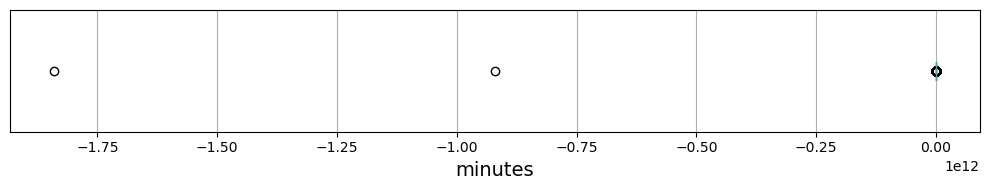

In [21]:
# visualize histrogram for duration
fig, ax = plt.subplots(figsize=(10, 2), dpi=100)
# boxplot
error_df.boxplot(column='raw', ax=ax, vert=False, color='#5f9ea0')
#ax.set_title('Total Rain (mm) for Each Event')
ax.set_xlabel('minutes', fontsize=14)
# remove y-axis
ax.set_yticks([])
plt.tight_layout()
#plt.savefig(save_folder / 'duration_boxplot.png', dpi=100)
plt.show()
plt.close()

There are some extremely low values

## Average error duration

In [22]:

error_groups = []

for sensor in tqdm(natural_sensor_order, total=len(natural_sensor_order)):
    sensor_error_df = error_df[error_df['sensor'] == sensor].copy()

    for error in error_indicators:
        _error_df = sensor_error_df[sensor_error_df[error] == True].copy()

        if len(_error_df) > 0:
            # Ensure the index is datetime
            if not pd.api.types.is_datetime64_any_dtype(_error_df.index):
                raise ValueError("Index must be a datetime type")

            # Calculate the difference in minutes between consecutive timestamps
            _error_df['time_diff'] = _error_df.index.to_series().diff().dt.total_seconds() / 60
            # replace the first value with 2 (for cumsum to start at 2 as well)
            _error_df['time_diff'].fillna(2, inplace=True)

            # Identify groups where time difference is not 1 minute apart
            _error_df['group'] = (_error_df['time_diff'] != 1).cumsum() 

            # Replace time difference of 1 with NaN and forward fill
            _error_df['time_diff'] = _error_df['time_diff'].replace(1, np.nan).ffill()

            # Iterate each group
            for group, group_df in _error_df.groupby('group'):
                duration = len(group_df)
                error_groups.append((sensor, error, duration))

error_groups_df = pd.DataFrame(error_groups, columns=['sensor', 'error', 'duration'])

100%|██████████| 19/19 [00:06<00:00,  2.82it/s]


In [23]:
# Calculate mean and standard deviation
grouped = error_groups_df.groupby(['error']).agg(
    mean_duration=('duration', 'mean'),
    std_duration=('duration', 'std')
).reset_index()

In [24]:
grouped['mean_duration'] = grouped['mean_duration'].round(2)

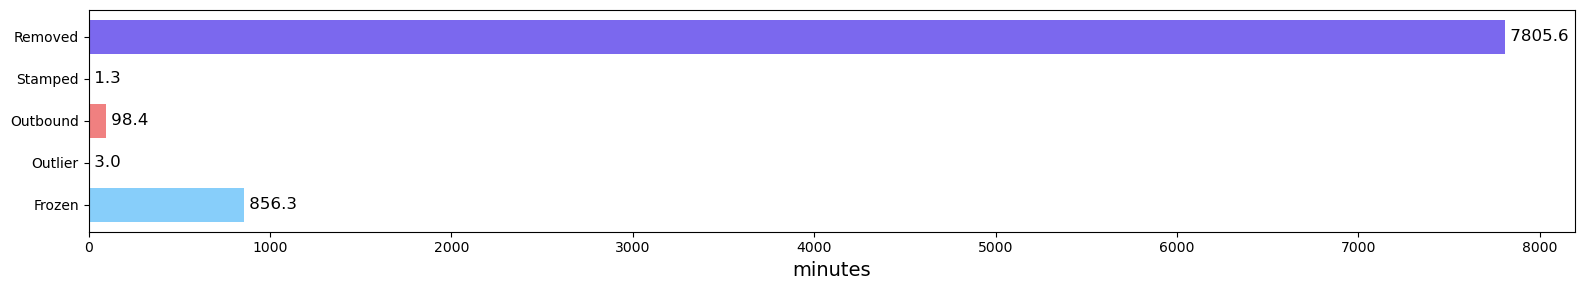

In [25]:
# plot barplot
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

aliases = []
for i, error in enumerate(error_indicators):
    error_meta = bools_2_meta[error]
    aliases.append(error_meta['alias'])
    # visualize barplot
    mean_duration = grouped[grouped['error'] == error]['mean_duration'].values[0]
    ax.barh(error, mean_duration, color=error_meta['color'])
    ax.text(mean_duration, i, f' {mean_duration:.1f}', ha='left', va='center', color='black', fontsize=12)

# Set custom y-ticks and labels
ax.set_yticks(range(len(error_indicators)))
ax.set_yticklabels(aliases)

# invert y-axis
ax.invert_yaxis()
ax.set_xlabel('minutes', fontsize=14)

plt.tight_layout()
plt.savefig(save_folder / 'avg_error_duration.png', dpi=200)
plt.show()
plt.close()